In [91]:
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [92]:
import math
from pathlib import Path
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import persim
import ripser
from rich import print as rprint
from safetensors import safe_open
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, Subset

from analysis.utils import load_autoencoder, load_model
from koopmann.aesthetics import ibmplexsans, kill_axes, kill_ticks
from koopmann.data import DatasetConfig, get_dataset_class
from koopmann.shape_metrics import prepare_acts
from koopmann.utils import get_device, set_seed

set_seed(21)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0 -> 1e0

1 -> 1e-1

2 -> 1e-2

3 -> 1e-3

4 -> 1e-4

Control panel

In [93]:
mlp_file_dir = "/Users/nsa325/koopmann_model_saves"
ae_file_dir = "/Users/nsa325/koopmann_model_saves/isometry_study"
data_root = "/Users/nsa325/datasets/"
dataset_name = "yinyang"
model_name = f"resmlp8_{dataset_name}"
device = get_device()

In [94]:
model, model_metadata = load_model(mlp_file_dir, model_name)
model.hook_model().eval().to(device)
rprint("MLP Metadata: ", model_metadata)

MLP Metadata: 
{
    'batchnorm': True,
    'bias': True,
    'created_at': '2025-05-05T16:23:51.006581',
    'dataset': 'YinYangDataset',
    'hidden_config': [10, 10, 10, 10, 10, 10, 10, 10],
    'in_features': 2,
    'model_class': 'ResMLP',
    'nonlinearity': 'relu',
    'out_features': 3,
    'stochastic_depth_mode': 'batch',
    'stochastic_depth_prob': 0.0
}

In [95]:
# Build dataset
dataset_config = DatasetConfig(
    dataset_name=model_metadata["dataset"], num_samples=5_000, split="train", seed=42
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
dataset = DatasetClass(config=dataset_config, root=data_root)

# Grab subset of dataset
subset_size = 2_000
if subset_size:
    subset_indices = list(range(0, subset_size))
    subset = Subset(dataset, subset_indices)

# Make dataloader
batch_size = 5_000
batch_size = min(subset_size, batch_size) if subset_size else batch_size
dataloader = DataLoader(subset if subset_size else dataset, batch_size=batch_size, shuffle=False)

In [96]:
if dataset_name == "yinyang":
    dim = 20
    k_steps = 100
    scale_idx = 1
    flavor = "exponential"
else:
    raise NotImplementedError()

ae_name = f"dim_{dim}_k_{k_steps}_loc_{scale_idx}_{flavor}_autoencoder_{dataset_name}_model"
device = get_device()

In [97]:
ae_files = sorted(os.listdir(ae_file_dir))
ae_files = [
    Path(file) for file in ae_files if ("autoencoder" in file and "preprocessing" not in file)
]

In [98]:
autoencoders_list = []
# autoencoder_preprocs_list = []
for ae_file in ae_files:
    autoencoder, ae_metadata = load_autoencoder(ae_file_dir, ae_file.stem)
    autoencoders_list.append(autoencoder.eval().to(device))

    preproc_dict = {}
    with safe_open(
        f"{ae_file_dir}/{ae_file.stem}_preprocessing.safetensors", framework="pt", device=device
    ) as f:
        for k in f.keys():
            preproc_dict[k] = f.get_tensor(k)

    # autoencoder_preprocs_list.append(preproc_dict)
    rprint(ae_file.stem)
    # rprint("Autoencoder: ", ae_metadata)

0_dim_20_k_100_loc_1_exponential_autoencoder_yinyang_model

3_dim_20_k_100_loc_1_exponential_autoencoder_yinyang_model

dim_20_k_100_loc_1_exponential_autoencoder_yinyang_model

In [99]:
orig_act_dict, processed_act_dict, _ = prepare_acts(
    data_train_loader=dataloader,
    model=model,
    device=device,
    svd_dim=ae_metadata["in_features"],
    whiten_alpha=preproc_dict["wh_alpha_0"],
    preprocess=True,
    preprocess_dict=preproc_dict,
    only_first_last=True,
)

Processing activations:   0%|          | 0/2 [00:00<?, ?it/s]/Users/nsa325/git/koopmann/koopmann/shape_metrics.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preprocess_dict[wh_alpha_key] = torch.tensor(whiten_alpha)
Processing activations: 100%|██████████| 2/2 [00:00<00:00, 61.80it/s]


In [100]:
def compare_betti_curves(ax, ripser_outputs, labels, dim):
    if dim > 1 or dim < 0:
        raise NotImplementedError()
    all_values = [
        v
        for output in ripser_outputs
        for pair in output["dgms"][dim]  # Using dim here
        for v in pair
        if not np.isinf(v)
    ]
    min_val, max_val = min(min(all_values), 0), max(all_values)

    filt_vals = np.linspace(min_val, max_val, 200)
    colors = ["#353531", "#EC4E20", "#FF9505", "#4c3191"]

    for i, (output, label) in enumerate(zip(ripser_outputs, labels)):
        # Use the selected dimension
        dgm = output["dgms"][dim]  # Changed from fixed 0 to dim
        betti = np.zeros(len(filt_vals))
        for birth, death in dgm:
            death = max_val if np.isinf(death) else death
            alive = (filt_vals >= birth) & (filt_vals < death)
            betti[alive] += 1

        ax.plot(
            filt_vals,
            betti,
            label=f"{label}",  # Updated to use dim
            color=colors[i % len(colors)],
            linewidth=4,
        )

    # Add these to complete the function
    ax.set_xlabel("Filtration")
    ax.set_ylabel(f"β{dim}")
    sns.despine()
    kill_ticks(ax)
    if dim == 0:
        ax.legend()
    # ax.grid(True, alpha=0.3)


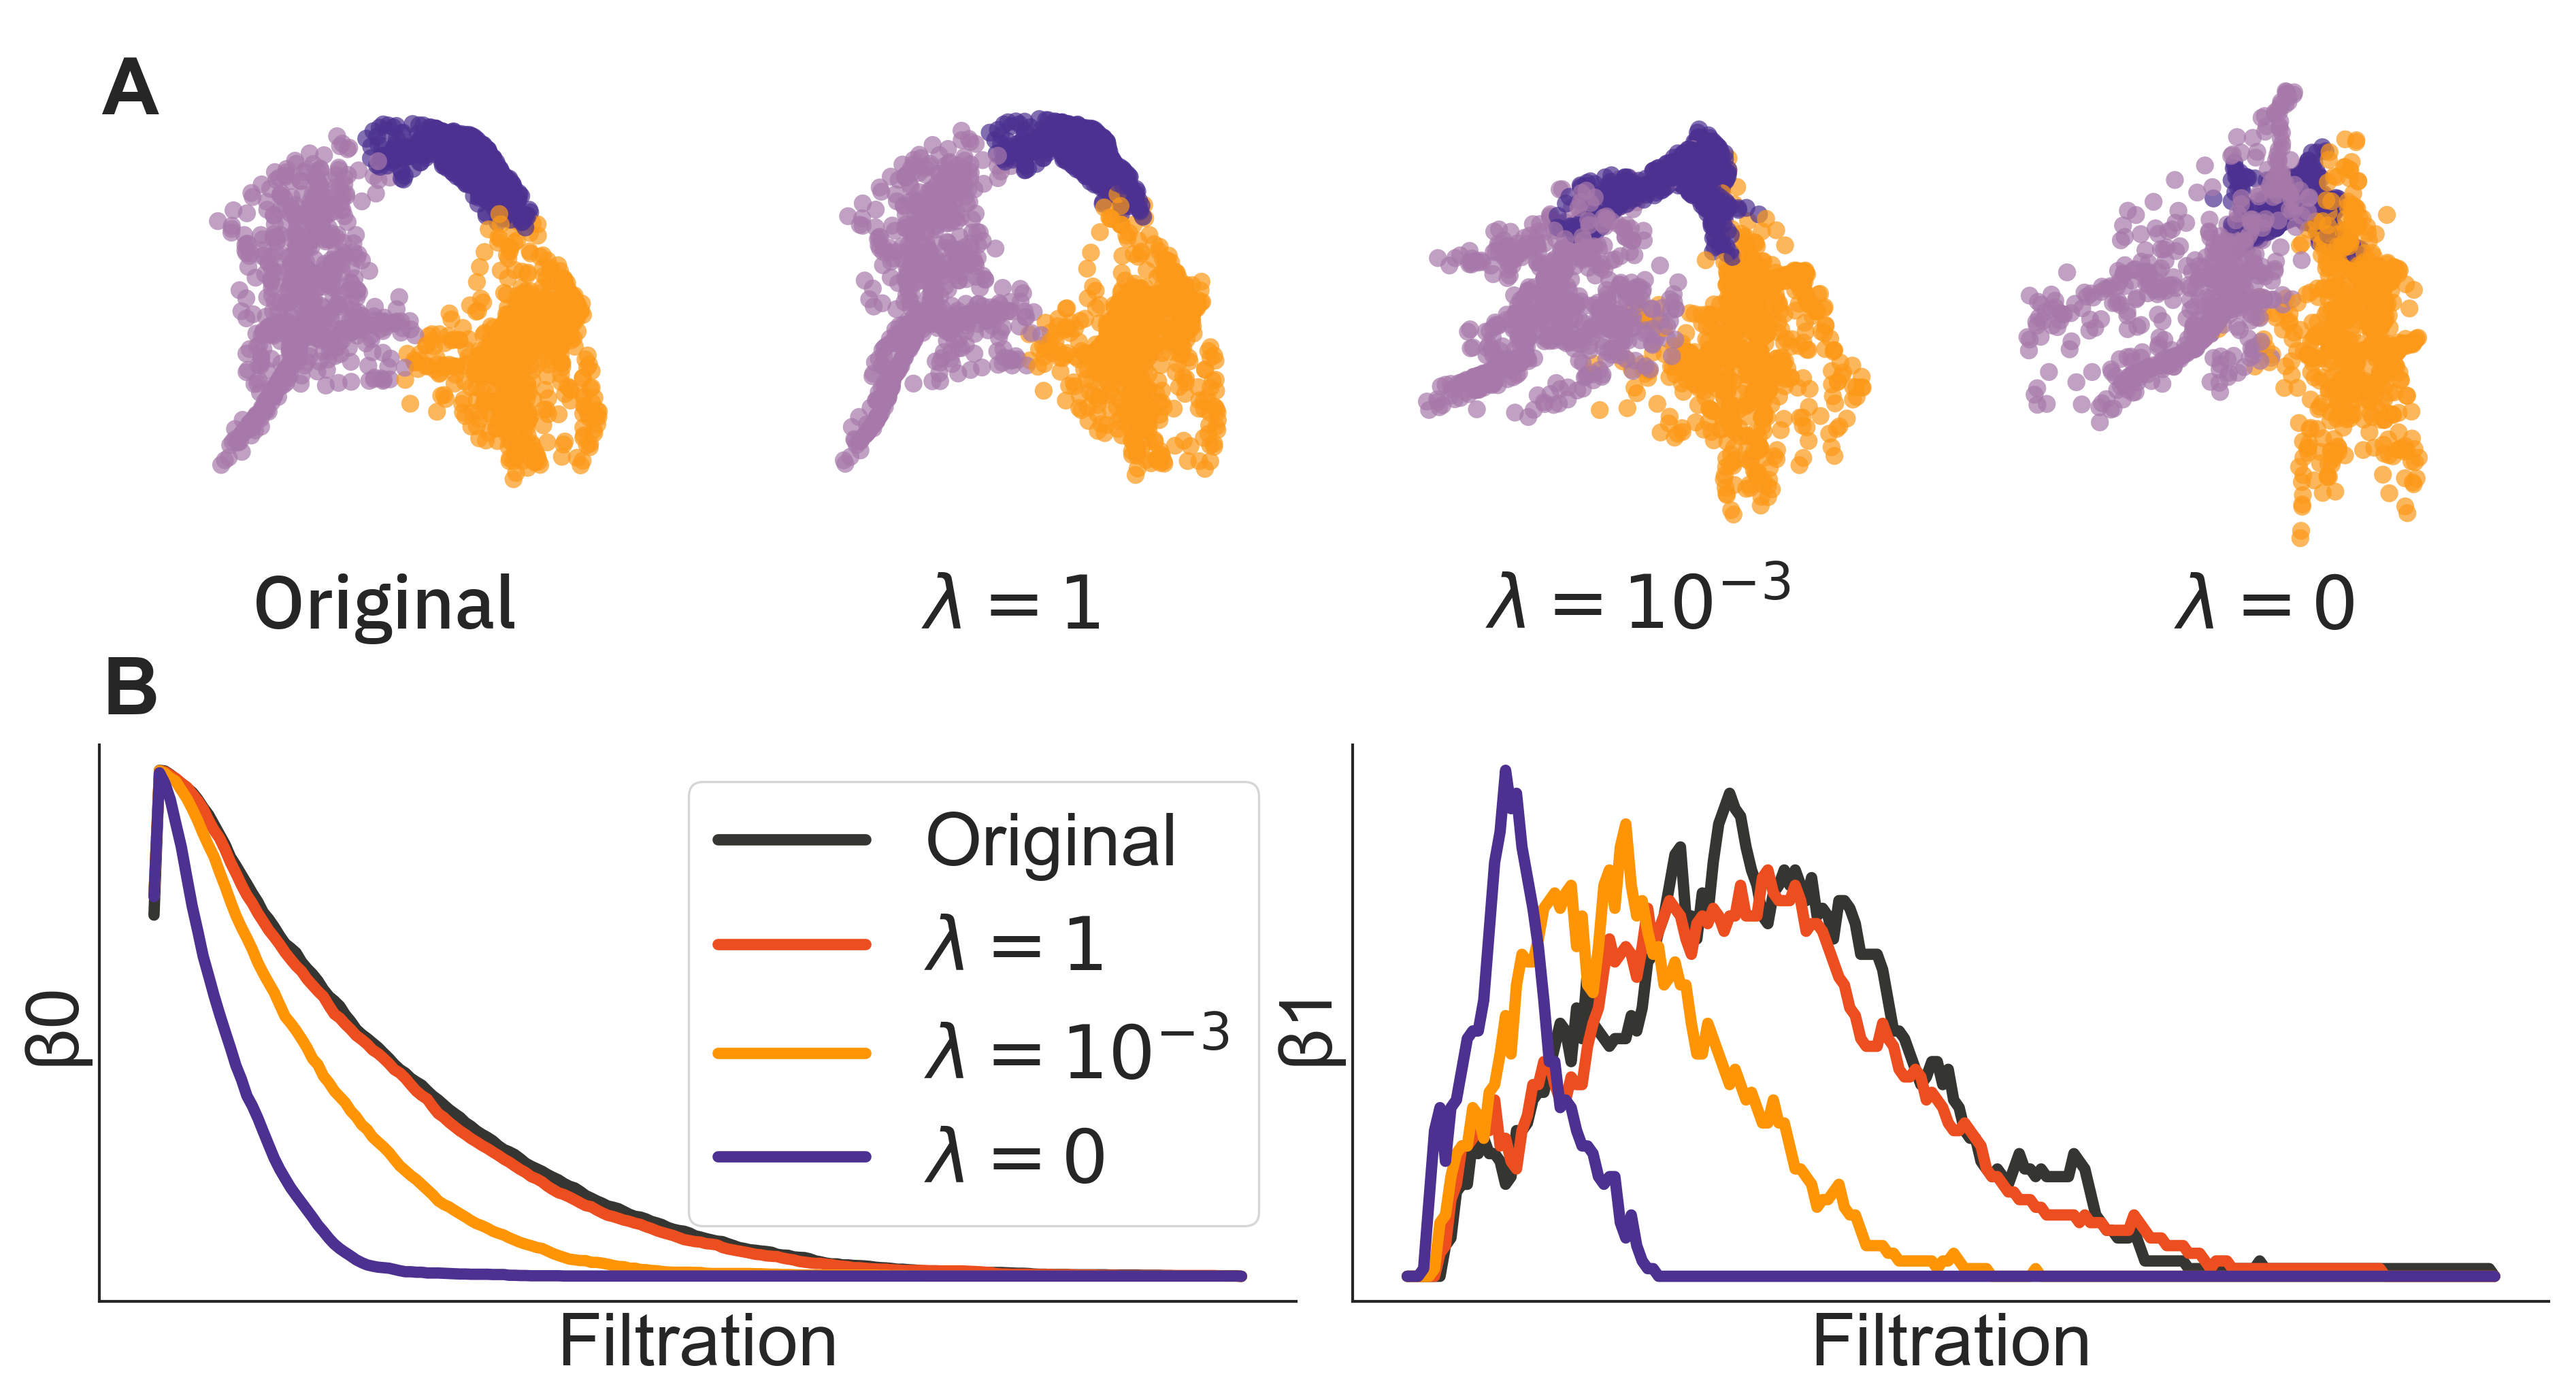

In [103]:
# Data for first row
key = 8
coords_list = [processed_act_dict[key].cpu()]
titles = ["Original", r"$\lambda=1$", r"$\lambda=10^{-3}$", r"$\lambda=0$"]
for ae in autoencoders_list:
    coords_list.append(ae.encode(processed_act_dict[key]).detach().cpu())
labels = [str(t) for t in dataset.labels[:subset_size]]
classes = sorted(set(labels))

# Data for second row
ripser_results = []
for coords in coords_list:
    ripser_results.append(ripser.ripser(coords, thresh=5))

# Colors
palette = ["#fc9918", "#a779aa", "#4c3191"]
colors = [palette[classes.index(cat) % len(palette)] for cat in labels]

# Create grid of subplots
n_cols = len(coords_list)
n_rows = 2
fig = plt.figure(figsize=(3 * n_cols, 3 * n_rows), dpi=300)
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, wspace=0.1, hspace=0.2)
gs.update(left=0, right=1, top=1, bottom=0)

# Create a reference
pca = PCA(n_components=3)
reference = pca.fit_transform(coords_list[0])

# Plot scatter
for i, coords in enumerate(coords_list):
    # PCA and align
    red_coords = pca.fit_transform(coords)
    _, red_coords, _ = procrustes(reference, red_coords)

    # Scatter
    ax = fig.add_subplot(gs[0, i], projection="3d")
    ax.scatter(
        red_coords[:, 0],
        red_coords[:, 1],
        red_coords[:, 2],
        s=40,
        c=colors,
        alpha=0.7,
        edgecolors="none",
    )
    ax.text2D(
        0.5, 0.01, titles[i], fontsize=26, font=ibmplexsans, ha="center", transform=ax.transAxes
    )

    # Clean appearance
    kill_ticks(ax)
    kill_axes(ax)
    ax.margins(0, 0, 0)  # Remove any internal margins

    # Set consistent view angle
    ax.view_init(elev=-90, azim=130)
    ax.set_box_aspect([1, 1, 1], zoom=1.3)


plt.rcParams.update(
    {
        "font.size": 26,
        "axes.labelsize": 26,
        "axes.titlesize": 26,
        # "xtick.labelsize": 24,
        # "ytick.labelsize": 20,
        "legend.fontsize": 26,
    }
)

ax = fig.add_subplot(gs[1, :2])
compare_betti_curves(ax, ripser_results, titles, dim=0)

ax = fig.add_subplot(gs[1, 2:])
compare_betti_curves(ax, ripser_results, titles, dim=1)

fig.text(0.001, 0.97, "A", fontsize=28, weight="bold")
fig.text(0.001, 0.48, "B", fontsize=28, weight="bold")

# Save with minimal borders
plt.savefig("isometry.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()